In [1]:
import re
from functools import reduce
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Pre-Processing

In [2]:
batch_size = 300
vocab_size = 20000

In [3]:
df = pd.read_csv('IMDB Dataset.csv')
df['sentiment'] = (df['sentiment'] == 'positive').astype(int)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [4]:
print(f"average word count: {np.mean(df['review'].apply(lambda x: len(x.split())))}")

average word count: 231.15694


In [5]:
# clean a string and get the vocab words from it
def get_words(string):
    string = string.lower().replace('<br />', ' ') # <br /> tags frequently appear, remove them
    return re.findall(r'[a-z]+', string)

# create and clean the vocabulary
text_corpus = ' '.join(df['review'])
words = get_words(text_corpus)

# take the x most common words, otherwise we get a vocab of 100000
word_counts = Counter(words)
words = sorted(word_counts.items(), reverse=True, key=lambda x: x[1])[:vocab_size-4]
words = list(list(zip(*words))[0]) # remove the counts
words = ['<MASK>', '<UNK>', '<START>', '<END>'] + words # add the tokens

In [6]:
# create the dictionaries to store the vocab
vocab_idx = {}
idx_vocab = {}
for i, word in enumerate(words):
    if word not in vocab_idx:
        vocab_idx[word] = i
        idx_vocab[i] = word
print(f"number of unique words: {len(vocab_idx)}")

number of unique words: 20000


In [7]:
# convert a string to a list of indexes of its words
# also add start and end tokens along with right padding
def string_to_idxs(string):
    idxs = list(map(lambda x: vocab_idx[x] if x in vocab_idx else 1, get_words(string)))
    idxs = [2] + idxs[-(batch_size-2):] + [3] # crop to the batch_size and add the start and end tokens
    padding = np.zeros((batch_size - len(idxs))) + 0
    idxs = np.concatenate([idxs, padding]).astype(int)
    return idxs

In [8]:
def index_to_string(idxes):
    return ' '.join(list(map(lambda x: idx_vocab[x], idxes)))

In [9]:
# create a column that represents reviews a list of the words' indexes in the vocab
df['idxed_review'] = df['review'].apply(string_to_idxs)
df['idxed_review']

0        [2, 32, 3176, 35, 28, 207, 17, 13, 9, 616, 50,...
1        [2, 6, 393, 123, 353, 4, 1370, 2952, 9, 56, 17...
2        [2, 12, 194, 13, 16, 6, 393, 98, 8, 1141, 60, ...
3        [2, 679, 42, 15, 6, 229, 118, 6, 123, 400, 332...
4        [2, 1, 10477, 15, 113, 11, 4, 60, 7, 292, 9, 6...
                               ...                        
49995    [2, 12, 194, 13, 18, 120, 6, 179, 207, 52, 297...
49996    [2, 77, 114, 77, 411, 77, 117, 3007, 961, 4, 6...
49997    [2, 12, 233, 6, 3398, 4364, 11, 1, 8165, 5462,...
49998    [2, 12, 141, 170, 8, 30, 8, 2983, 20, 4, 919, ...
49999    [2, 59, 31, 5822, 4, 324, 2082, 101, 8, 32, 30...
Name: idxed_review, Length: 50000, dtype: object

#### Build training and test set
Training set has no closures and is a language modelling task

Test set has the closures and is a classification task

In [10]:
# turn the review column into a multi dimensional array
review_array = np.concatenate(df['idxed_review']).reshape(df.shape[0], batch_size)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(review_array, np.array(df['sentiment']), test_size=0.1)

In [12]:
# the label for each word is the next word in the seqeunce, we also add a pad token at the end to keep the dimensions the same
y_train = np.concatenate([X_train[:, 1:], np.ones((X_train.shape[0], 0)).astype(int)], axis=1)
y_train

array([[ 155,   24,  183, ...,  311, 6829,    3],
       [  31,    7,    1, ...,    0,    0,    0],
       [  13,   31,  115, ...,   78,   13,    3],
       ...,
       [   6, 6828,    5, ...,    0,    0,    0],
       [  11, 1386, 4951, ...,    4, 4708,    3],
       [  13,   18,   16, ...,    0,    0,    0]])

In [13]:
X_train

array([[   2,  155,   24, ...,  311, 6829,    3],
       [   2,   31,    7, ...,    0,    0,    0],
       [   2,   13,   31, ...,   78,   13,    3],
       ...,
       [   2,    6, 6828, ...,    0,    0,    0],
       [   2,   11, 1386, ...,    4, 4708,    3],
       [   2,   13,   18, ...,    0,    0,    0]])

### Model Building
- First train an LSTM as a language model, then have it solve closures to get the predictions
- Because the data would be too large to fit in memory if we converted it to one hot, we have to instead train using a generator (takes integers representing words and outputs a one hot vector
- Clozure to start with: "X + Overall this movie was (poor/great)"  (figure out how to do Bidirectional LSTM without it just predicting \<MASK\> later)

In [14]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout
tf.config.list_physical_devices('GPU') # check gpu is in use

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
# Create the generator class, it yields one review and its labels at a time
class SampleSequence(tf.keras.utils.Sequence): # extend Seqeunce so that we can use multiprocessing
    def __init__(self, X_train):
        self.X = X_train
        
    def __len__(self):
        return self.X.shape[0]
        
    # get item at the index specified
    def __getitem__(self, idx):
        # the pad_token is used for creating the labels
        pad_token = np.zeros((1, vocab_size))
        pad_token[0, 0] = 1
        
        x_sample = self.X[idx, :].reshape(1, batch_size) # the embedding layer automatically handles integers
        y_sample = np.zeros((batch_size, vocab_size)) # the labels need to be manually converted to one hot
        for i in range(batch_size - 1):
            y_sample[i, self.X[idx, i+1]] = 1  # the label at step1 is the word at step2
        y_sample[-1, :] = pad_token # add the pad token for the 300th step's label
        y_sample = y_sample.reshape(1, batch_size, vocab_size)
            
        return (x_sample, y_sample)

In [16]:
# Do the same thing but with a tensorflow dataset implementation, this allows parralelization 
# first define the mapping function to convert a tensor of X_train into an X, y sample
pad_token = np.zeros((1, vocab_size))
pad_token[0, 0] = 1
pad_token = tf.constant(pad_token, dtype='float32')
def text_to_sample(x_tensor): # takes a single sample and converts it to input text and ouput labels
    y_one_hot = tf.one_hot(x_tensor, vocab_size, axis=-1) # axos=-1 means we get a tensor of shape (features, vocab_size)
    y_one_hot = y_one_hot[1:, :] # shift back one
    y_one_hot = tf.concat([y_one_hot, pad_token], axis=0) # add pad token at the end 
    x_tensor = tf.reshape(x_tensor, [1, batch_size])
    return (x_tensor, y_one_hot)

# create training Dataset, apply the function to create the pipeline
def create_dataset(data):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.map(text_to_sample)
    return dataset

training = create_dataset(X_train)
testing = create_dataset(X_test)

In [17]:
# Create the model, eventually this should be bi-directional
# This architecture was borrowed from here: https://adventuresinmachinelearning.com/keras-lstm-tutorial/
model = Sequential()
model.add(Embedding(vocab_size, 500, input_length=batch_size, mask_zero=True))
model.add(LSTM(500, return_sequences=True,
              activation='tanh', recurrent_activation='sigmoid',
              dropout=0, recurrent_dropout=0))
model.add(LSTM(500, return_sequences=True,
              activation='tanh', recurrent_activation='sigmoid',
              dropout=0, recurrent_dropout=0))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(20000, activation='softmax')))
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 500)          10000000  
_________________________________________________________________
lstm (LSTM)                  (None, 300, 500)          2002000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 500)          2002000   
_________________________________________________________________
dropout (Dropout)            (None, 300, 500)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 300, 20000)        10020000  
Total params: 24,024,000
Trainable params: 24,024,000
Non-trainable params: 0
_________________________________________________________________


In [28]:
# With CUDNN implementation it runs faster, does take a lot of time to begin though
history = model.fit(x=create_dataset(X_train), validation_data=create_dataset(X_test), epochs=50, 
                    use_multiprocessing=True, # allows multiple cpu cores to work on generating data samples at once
                    max_queue_size=50, # size of the queue of training items the cpu will create
                    workers=4) # number of processes that will generate items

Train for 45000 steps, validate for 5000 steps
Epoch 1/50
45000/45000 [==============================] - 3801s 84ms/step - loss: 3.2874 - categorical_accuracy: 0.1894 - val_loss: 3.2041 - val_categorical_accuracy: 0.1981
Epoch 2/50
45000/45000 [==============================] - 3750s 83ms/step - loss: 3.2624 - categorical_accuracy: 0.1928 - val_loss: 3.1838 - val_categorical_accuracy: 0.2009
Epoch 3/50
45000/45000 [==============================] - 3831s 85ms/step - loss: 3.2403 - categorical_accuracy: 0.1959 - val_loss: 3.1662 - val_categorical_accuracy: 0.2033
Epoch 4/50
45000/45000 [==============================] - 3836s 85ms/step - loss: 3.2213 - categorical_accuracy: 0.1987 - val_loss: 3.1509 - val_categorical_accuracy: 0.2059
Epoch 5/50
45000/45000 [==============================] - 3828s 85ms/step - loss: 3.2034 - categorical_accuracy: 0.2012 - val_loss: 3.1376 - val_categorical_accuracy: 0.2075
Epoch 6/50
45000/45000 [==============================] - 3824s 85ms/step - loss: 3

In [17]:
# uncomment these lines to use them
# model.save("language_model.h5")
model = tf.keras.models.load_model("language_model.h5")

In [18]:
preds = model.predict(create_dataset(X_test[:100]))

In [19]:
labels = X_test[:1000, 1:300]

In [20]:
item = 2
index_to_string(X_test[item])

'<START> it has been years since it s original run i would have hoped by now some marketing wizard would have promoted a live actor version of this classic by now or at least sought to re release the original episodes i can t fathom why the sci fi or cartoon network haven t snapped this up galaxy rangers actually had well thought out plots and even better scripts the animation was above average quality for it s time and excellent when compared to the talking slide show japanese animation of today it <UNK> the heavy toon toy tie in market this may have sealed it s doom too i would willingly spend cash on a dvd of gr if available <END> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <

In [21]:
index_to_string(np.argmax(preds[item], axis=1))

'i s been a since i was a and i m like to it the that of and <UNK> have been a <UNK> action of of the film in the i even least a to be <UNK> it original version and have t wait how the show fi channel sci network would t been it up and <UNK> is were a to out and and i the films and <UNK> was <UNK> average and and the s time and the acting i to the original <UNK> show the series of the s was the <UNK> <UNK> <UNK> <UNK> in the i is be been the s <UNK> it it m recommend recommend the on a dvd of the s you on <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK>

In [22]:
np.flip(np.argsort(preds[58, 100]))[:20]

array([    0, 18562, 16679, 19721, 18461,  9055, 19774, 17816, 19892,
       19319, 19434, 19920, 18342, 17951,     2, 19876, 16874, 17853,
       18764, 19919], dtype=int64)

### Closure Creation 
Analyse performance on the test set given by solving closure problems

In [23]:
closures = np.zeros(X_test.shape, dtype='int')
prompt = "Overall the movie was"
for i in range(X_test.shape[0]):
    review = index_to_string(X_test[i]).replace('<MASK> ', '').replace('<END> ', '').strip() # convert to string, removing the <END> and <MASK> tokens
    closures[i, :] = string_to_idxs(review + " " + prompt)
closures = create_dataset(closures)

In [24]:
# we need to perform prediction in steps as otherwise the output doesn't fit in memory
def generator_predict(closures):
    for data in closures:
        # find the last index that's not a zero in the input data (by looping back from the end to the first non-zero entry)
        # then use that to get the prediction at the end
        for i in range(batch_size - 1, -1, -1):
            if data[0][0, i] != 0: break # data[0] is the input sequence, data[0][0 - the first sample, i - ith word]
        
        # take the prediction for the last word in the text before masking tokens
        pred = model.predict(data)[0, i - 1, :] # i is the position of the end token 3, take the prediction for 1 further back
        yield pred

In [25]:
test = closures.as_numpy_iterator()

In [26]:
next(test)

(array([[    2,  2463,  9856,   261,   118,   120,    27,   845,     8,
            81,  1009,     5,    92,     7,    95,    30,    77,   211,
             1,    17,    72,     4,  1310,     1,    33,     1,    69,
             1,   196,     8,    97,    23,   422,     4,    52,   211,
          5735,  2807,    80,   182,     6,  2700,  3208,  3606, 11481,
           838,    11,    29,  4876,    44,  2573,    10,    46,     5,
          1595,   307,     9,   778,     4,  2761,    20,    59,  5791,
            34,    33,  7145,  1493,   980,   935,    12,   105,   285,
          5158,     8,     6,    11,     4,  4036,    64,    27,  2555,
            46,    36, 10620,     6,     1,   187,    29,  3843,  4036,
             5,  8624,    27,  1165,    49,     6,  7812,   443,  5237,
          1838,    11,    64,    27, 17862,  2595,  5850,     8,     4,
           388,    17,    72,    17,   112,   490,     1,    91,    86,
             6,  1256,  1932,     6,   768,  5947,    40,    50,

In [27]:
next(generator_predict(closures))

array([6.4843495e-09, 6.8171727e-03, 1.8615570e-09, ..., 2.3755327e-08,
       4.7915944e-07, 2.1847498e-08], dtype=float32)

In [28]:
# calculate the predicted probabilities
pred_probas = [] # the probability that the next word is "Good" if it must by Good or Bad
for i, pred in enumerate(generator_predict(closures)):
    good_prob = pred[vocab_idx['good']] # great
    bad_prob = pred[vocab_idx['bad']]   # poor
    total = good_prob + bad_prob
    pred_probas.append(good_prob/(good_prob + bad_prob)) 

In [29]:
# Find the cutoff that gives the highest accuracy
pred_probas = np.array(pred_probas)
c_range = np.arange(0, 1, 0.001)
accuracies = []
for cutoff in c_range:
    class_preds = (pred_probas > cutoff).astype(int)
    accuracies.append(accuracy_score(y_test, class_preds))

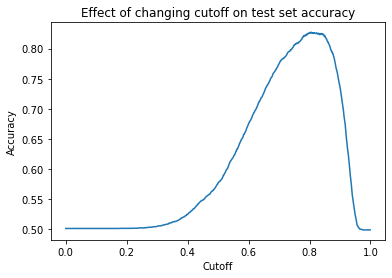

In [30]:
plt.plot(c_range, accuracies)
plt.title("Effect of changing cutoff on test set accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Cutoff")
plt.show()